## Stage 01: Problem Framing & Scoping

### Problem Statement
This project develops an Industry Multi-Factor Rotation Model aimed at enhancing portfolio allocation strategies. By analyzing factor exposures (such as value, momentum, quality, and risk) across industries, the model seeks to identify which industries are expected to outperform and rotate capital accordingly.

The objective is to provide a systematic, data-driven approach to industry allocation that can adapt to changing market conditions.

## Stage 02: Tooling Setup

### Environment & Libraries
We begin by importing the core Python libraries required for data handling, analysis, and visualization.

In [ ]:
# Ricequant Database
import rqdatac
import os
from dotenv import load_dotenv

load_dotenv()
rq_token = os.getenv("RICEQUANT_API_TOKEN")
try:
    rqdatac.init(
                username = "license",
                password = rq_token, #Ricequant API account
                addr=("rqdatad-pro.ricequant.com", 16011),
                use_pool=True,
                max_pool_size=1,
                auto_load_plugins=False,
            )
    #rqdatac.info()
    #rqdatac.user.get_quota() Get account traffic quota
except Exception as e:
    print(e)
    # logger.info(e)
    
import pandas as pd 
import numpy as np
from data_clean import *
from rqdatac import *
from rqfactor import *
from rqfactor.notebook import *
from rqfactor.extension import *
import matplotlib.pyplot as plt

C:\ProgramData\anaconda3\Lib\site-packages\rqdatac\client.py:241: UserWarning: Your account will be expired after  66 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


## Stage03: python_fundamentals

In [ ]:
#Calculate stock pool
def calculate_stock_pool(start_date, end_date, index_item):
    index = pd.DataFrame()
    trade_days = get_trading_dates(start_date, end_date, market='cn')  
    for i in trade_days:
        index_day = pd.DataFrame(rqdatac.index_components(index_item, i),columns = [i]).T
        index = pd.concat([index,index_day],axis = 0)
        print('\r 当前：{} / 总量：{}'.format(i,trade_days[-1]),end='')
    print()    
    
    # Dynamic stock pool 
    index_fix = index.unstack().reset_index().iloc[:,-2:]
    index_fix.columns = ['date','stock']
    index_fix.date = pd.to_datetime(index_fix.date)
    index_fix['level'] = True
    index_fix.dropna(inplace = True)
    index_fix = index_fix.drop_duplicates(subset=['date','stock'], keep='first').set_index(['date','stock']).unstack()
    index_fix.fillna(False,inplace = True)
    index_fix = index_fix.T.reset_index().iloc[:,1:].set_index(['stock']).T

    return trade_days, index_fix


#Get factor data
def get_factor_data(trade_days, index_fix, expression):
    stock_list_whole = index_fix.columns.tolist()
    start_date = trade_days[0]
    end_date = trade_days[-1]
    try:
        cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)
    except:
        try:
            cfoa = get_consensus_comp_indicators(stock_list_whole, start_date, end_date, expression)[expression]
            cfoa = cfoa.unstack(level=0) 
            cfoa.columns.name = None
            cfoa.index.name = None
            cfoa = cfoa.astype(float)
            if expression != 'comp_con_eps_ftm':
                cfoa= 1/cfoa
        except:
            cfoa = search_for_factor(expression, stock_list_whole, start_date, end_date)
            cfoa.columns.name = None
            cfoa.index.name = None
        
    return cfoa


#Find high-frequency factors
def search_for_factor(expression, stock_list_whole, start_date, end_date):
    # Create a copy of DataFrame to avoid affecting the original data
    df = data_df.copy()
    
    # Convert start_date and end_date to datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Select only necessary columns and filter rows by date
    df = df[['S_INFO_WINDCODE', 'TRADE_DT', expression]]
    df = df[(df['TRADE_DT'] >= start_date) & (df['TRADE_DT'] <= end_date)]
    df.set_index('TRADE_DT', inplace=True)

    # Modify stock code format
    df['S_INFO_WINDCODE'] = df['S_INFO_WINDCODE'].str.replace('.SH', '.XSHG')
    df['S_INFO_WINDCODE'] = df['S_INFO_WINDCODE'].str.replace('.SZ', '.XSHE')

    # Keep only the required stock list
    df = df[df['S_INFO_WINDCODE'].isin(stock_list_whole)]

    # Pivot the DataFrame so that each stock is a column
    result_df = df.pivot(columns='S_INFO_WINDCODE')

    # Remove the upper-level column names caused by pivoting
    result_df.columns = result_df.columns.droplevel()

    return result_df


#Obtain dates and securities, factor cleaning preprocessing
def process(factor,index_fix):
    stock_list_whole = index_fix.columns.tolist()
    date_list_whole = index_fix.index.tolist()
    
    new_stock_filter = get_new_stock_filter(stock_list_whole, date_list_whole)
    st_filter = get_st_filter(stock_list_whole, date_list_whole)
    suspended_filter = get_suspended_filter(stock_list_whole, date_list_whole)
    limit_up_down_filter = get_limit_up_down_filter(stock_list_whole, date_list_whole)
    
    return new_stock_filter, st_filter, suspended_filter, limit_up_down_filter
    
#Factor cleaning    
def factor_clean(factor,new_stock_filter,st_filter,suspended_filter,limit_up_down_filter,index_fix):
    
    # Exclude ST stocks, limit-up stocks, suspended stocks, and IPOs
    factor = factor.mask(new_stock_filter).mask(st_filter).mask(suspended_filter).mask(limit_up_down_filter).mask(~index_fix).dropna(how = 'all')
    print('券池过滤完毕')
    
    # Outlier processing
    factor = factor.apply(lambda x :filter_extreme_MAD(x,3), axis=1)
    
    # Standardization
    factor = factor.sub(factor.mean(axis=1), axis=0).div(factor.std(axis=1), axis=0) #add
    print('因子数据清洗完成，已剔除离群值、中性化处理')
    
    # Market-cap neutralization
    factor = market_cap_neutralization(factor)
    print('因子完成市值中性化')
    
    return factor
    
    
# Weighted calculation of industry factor values
def calculate_industry_factor(trade_days, index_item, cfoa):
      
    result_df = pd.DataFrame(index=trade_days, columns=['industry_factor'])
    for date in trade_days: 
            
        index_weight = index_weights(index_item, date)

        # Convert the dataset to a DataFrame
        index_weight_df = index_weight.reset_index()
        index_weight_df.columns = ['order_book_id', 'value']
        
        # Get the cleaned factor values for the daily stock pool
        daily_factor_values = cfoa.loc[(str(date), slice(None)), :]
        daily_factor_df = pd.DataFrame(daily_factor_values)
        daily_factor_df.reset_index(inplace=True)
        daily_factor_df=daily_factor_df.iloc[:,1:3]
        daily_factor_df.columns=['order_book_id','factor_value']

        # Merge DataFrames and compute
        merged_df=pd.merge(index_weight_df, daily_factor_df, on='order_book_id', how='left').dropna()
        total_sum = merged_df['value'].sum()
        merged_df['weight_normalized'] = merged_df['value'] / total_sum
        merged_df.drop('value', axis=1, inplace=True)
        industry_factor=merged_df.iloc[:, -2:].prod(axis=1).sum()
        result_df.loc[date] = [industry_factor]
        
    print('行业因子完成加权计算')
    
    return result_df


# Obtain cfoa
def get_cfoa(start_date, end_date, expression):
    # List of research index constituents
    all_instruments = rqdatac.all_instruments(type='CS')
    instruments_df = all_instruments['order_book_id']
    pieces = []
    for i in instruments_df:
        # Get the industry classification of the security
        piece = get_instrument_industry(i, source='sws', level=2, date=end_date, market='cn')
        pieces.append(piece)
        
    merged_data = pd.concat(pieces)
    sorted_data = merged_data.sort_values(by='second_industry_name')
    sector_codes = sorted_data['second_industry_code'].unique()

    # Use a dictionary to store each industry's factor values; keys are index tickers, values are factor DataFrames
    industry_factor_data = {}

    # Iterate over the list of index constituents
    for index_item in sector_codes:
        try:
            trade_days, index_fix = calculate_stock_pool(start_date, end_date, index_item)
            cfoa = get_factor_data(trade_days, index_fix, expression) 
            new_stock_filter, st_filter, suspended_filter, limit_up_down_filter = process(cfoa,index_fix)
            cfoa = factor_clean(cfoa, new_stock_filter, st_filter, suspended_filter, limit_up_down_filter, index_fix)
            result_df = calculate_industry_factor(trade_days, index_item, cfoa)
        except:
            print('{}行业指数因子值缺失构建失败'.format(index_item))
            print()
            continue
        
        # Save each index's result into the dictionary
        industry_factor_data[index_item] = result_df
        print('{}行业指数因子值已构建'.format(index_item))
        print()

    print('全部行业指数因子值已构建完成')

    # Combine results
    for key in industry_factor_data:
        industry_factor_data[key].columns = [key]

    combined_df = pd.concat(industry_factor_data.values(), axis=1)

    # Delete rows where all values are 0, transpose the DataFrame, reshape to MultiIndex, reorder index for display, and rename index
    stacked_df = (
        combined_df[~(combined_df==0).all(axis=1)].T
        .stack().swaplevel()
        .sort_index()
    )
    stacked_df.index.names = ['date', 'stock']

    # Convert the last column to float, reset the date index, convert date to datetime, and adjust index levels
    cfoa_processed = (
        stacked_df.astype(float).to_frame()
        .reset_index(level=0)
        .assign(date=lambda df: pd.to_datetime(df['date']))
        .set_index('date', append=True)
        .swaplevel(0,1)
    )
    
    return cfoa_processed


# Store data
def store_factor_data(factor_names, cfoa_dict):
    for factor_name in factor_names:
        
        # Copy data
        df = cfoa_dict[factor_name].copy()
        result = Group_Factor_Return_N_IC(df, 20)
        result.to_csv('{}_ic.csv'.format(factor_name))
        print(factor_name, ic_ir(result))

        # Use reset_index to convert a MultiIndex DataFrame to a single index
        df_reset = df.reset_index()

        # Reorder columns
        df_reset = df_reset[[0, 'date', 'stock']]

        # Write to CSV with ',' as separator, no index, preserving row order
        df_reset.to_csv(f"{factor_name}.csv", index=False, header=True)
    print('数据已存储完毕')
    print()

        
# Load data
def load_and_process_data(factor_names):
    loaded_data = {}
    ic_data = {}

    for factor_name in factor_names:
        # Read and process factor data
        df = pd.read_csv(f"{factor_name}.csv")
        df['date'] = pd.to_datetime(df['date'])
        df.set_index(["date", "stock"], inplace=True)
        df.sort_index(inplace=True)
        loaded_data[factor_name] = df
          
        # Read and process IC data
        df_ic = pd.read_csv(f"{factor_name}_ic.csv")
        df_ic['date'] = pd.to_datetime(df_ic['date'])
        df_ic.set_index(["date"], inplace=True)
        df_ic.sort_index(inplace=True)
        ic_data[factor_name] = df_ic
    print('数据已读取完毕')
    print()
    
    return loaded_data, ic_data


# Compose factor
def generate_factor_df(cfoa_dict, ic_dict, factor_names):
    # Merge DataFrames
    # Use pd.concat to join all DataFrames in cfoa_dict horizontally (axis=1)
    merged_cfoa_df = pd.concat(cfoa_dict.values(), axis=1, keys=cfoa_dict.keys())
    # Fill missing values in merged_cfoa_df with backfill method
    merged_cfoa_df.fillna(method='bfill', inplace=True)
    # Do the same for ic_dict
    merged_ic_df = pd.concat(ic_dict.values(), axis=1, keys=ic_dict.keys())
    # Drop the second level of the MultiIndex in merged_ic_df columns
    merged_ic_df.columns = merged_ic_df.columns.droplevel(1)

    # Convert indices to datetime 
    merged_ic_df.index = pd.to_datetime(merged_ic_df.index)
    merged_cfoa_df.index = merged_cfoa_df.index.set_levels([pd.to_datetime(merged_cfoa_df.index.levels[0]), merged_cfoa_df.index.levels[1]])

    # Merge the two DataFrames
    # Merge merged_cfoa_df and merged_ic_df on 'date', keeping all indices from the left DataFrame (merged_cfoa_df)
    merged_df = pd.merge(merged_cfoa_df.reset_index(), merged_ic_df.reset_index(), on='date', how='left', suffixes=('', '_ic'))

    # Create weight columns ('weighted'), and compute the weighted sum and the sum of absolute weights
    for col in factor_names:
        # Create a new weighted column as the product of col and itself
        merged_df[col + '_weighted'] = merged_df[(col, '0')] * merged_df[col]
    # Compute the weighted sum per row
    merged_df['weighted_sum'] = merged_df[[col + '_weighted' for col in factor_names]].sum(axis=1)
    # Compute the sum of absolute weights
    merged_df['abs_weight_sum'] = merged_df[[col for col in factor_names]].abs().sum(axis=1)

    # Normalize the weighted sum per row
    merged_df['normalized_weighted_sum'] = merged_df['weighted_sum'] / merged_df['abs_weight_sum']

    # Drop all rows containing NaN
    merged_df.dropna(inplace=True)
    # Extract the processed DataFrame, rename columns, and set index
    factor_df = merged_df[['date', ('stock', ''), 'normalized_weighted_sum']]
    factor_df = factor_df.rename(columns={factor_df.columns[1]: 'stock'})
    factor_df = factor_df.set_index(['date', 'stock'])

    return factor_df


# Analyze factor
def analyze_factor(factor_df):
    factor_result = Group_Factor_Return_N_IC(factor_df, 20)
    print(ic_ir(factor_result))

    group1_5_period, turnover = group_5(factor_df, 20)
    group1_5_period.columns = ['G1', 'G2', 'G3', 'G4', 'G5']
    group1_5_period['Benchmark'] = group1_5_period.mean(axis=1)
    group1_5_period = (group1_5_period + 1).cumprod()

    # Plot stratification effect test
    group1_5_period.plot(figsize=(15, 8), title='分层效应检验')
    plt.show()

    Down_Benchmark = -(group1_5_period['G1'] - group1_5_period['Benchmark'])
    Top_Benchmark = group1_5_period['G5'] - group1_5_period['Benchmark']
    Top_Down = group1_5_period['G5'] - group1_5_period['G1']
    TBD = pd.concat([Down_Benchmark, Top_Benchmark, Top_Down], axis=1)
    TBD.columns = ['Down_Benchmark', 'Top_Benchmark', 'Top_Down']

    # Plot long-short effect test
    TBD.plot(figsize=(15, 8), title='多空效应检验')
    plt.show()

    # Plot group turnover
    turnover.plot(figsize=(15, 8), title='分组换手率')
    plt.show()

    print(turnover.mean())
    

def factor_construction(start_date, end_date, factor_names, factor_expressions):
    cfoa_dict = {}
    for factor_name, expression in factor_expressions.items():
        cfoa = get_cfoa(start_date, end_date, expression)
        cfoa_dict[factor_name] = cfoa
        print('{}因子的行业合成已构建完成'.format(factor_name))
        print()

    # Store data
    store_factor_data(factor_names, cfoa_dict)

    # Load and process data
    loaded_data, ic_data = load_and_process_data(factor_names)

    # Compose factor
    factor_df = generate_factor_df(loaded_data, ic_data, factor_names)

    # Analyze factor
    analyze_factor(factor_df)
    
    return factor_df


def calculate_synthetic_factor(factor_dict, H):
    # Create an empty DataFrame whose row index matches each factor DataFrame
    synthetic_factor = pd.DataFrame(0, index=factor_dict[list(factor_dict.keys())[0]].index, columns=['normalized_weighted_sum'])
    # Number of factor categories
    factor_length = len(factor_dict)  
    # Initialize weight list
    weights = []  

    # For each factor category, compute and append the weight
    for i in range(factor_length):
        # Half-life weight calculation
        weight = 2**((i - factor_length - 1) / H)  
        weights.append(weight)  
    # Normalize the weights
    weights_normalized = np.array(weights) / np.sum(weights) 
    
    # For each factor category, compute its weighted factor values and add to the synthetic factor
    for i, factor_key in enumerate(factor_dict):
        factor_df = factor_dict[factor_key]
        synthetic_factor += factor_df * weights_normalized[i]
    synthetic_factor = synthetic_factor.rename(columns={'normalized_weighted_sum': 'synthetic_factor'})


    return synthetic_factor 

## Stage 04: Data Acquisition and Ingestion & Stage05: Data Storage

We acquire industry and factor data, typically from financial databases. The data includes:
- Industry return series
- Factor exposures (value, momentum, quality, risk)
- Benchmark index returns

This stage ensures that raw datasets are correctly loaded for subsequent processing.

start_date:2018-07-06
end_date:2023-07-06
Enter the half-life period:1
710300行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801203.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801724.INDX行业指数因子值已构建

460800行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801204.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801074.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
801981.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801155.INDX行业指数因子值已构建

280500行业指数因子值缺失构建失败

450600行业指数因子值缺失构建失败

340800行业指数因子值缺失构建失败

4606

剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801731.INDX行业指数因子值已构建

630700行业指数因子值缺失构建失败

630800行业指数因子值缺失构建失败

721000行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801111.INDX行业指数因子值已构建

340500行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801016.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801131.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801231.INDX行业指数因子值已构建

480300行业指数因子值缺失构建失败

240600行业指数因子值缺失构建失败

640700行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801741.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成

因子完成市值中性化
行业因子完成加权计算
801055.INDX行业指数因子值已构建

620600行业指数因子值缺失构建失败

640600行业指数因子值缺失构建失败

720500行业指数因子值缺失构建失败

720600行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801181.INDX行业指数因子值已构建

430300行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801721.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801881.INDX行业指数因子值已构建

461100行业指数因子值缺失构建失败

720700行业指数因子值缺失构建失败

360500行业指数因子值缺失构建失败

461000行业指数因子值缺失构建失败

450700行业指数因子值缺失构建失败

230400行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801132.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
801011.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801084.INDX行业指数因子值已构建

330700行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801082.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801733.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801017.INDX行业指数因子值已构建

650500行业指数因子值缺失构建失败

110900行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801012.INDX行业指数因子值已构建

220800行业指数因子值缺失构建失败

480500行业指数因子值缺失构建失败

230300行业指数因子值缺失构建失败

720900行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801018.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-

因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801713.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801722.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801101.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801193.INDX行业指数因子值已构建

340900行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801053.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801202.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801076.INDX行业指数因子值已构建

710400行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8968\4233184630.py:30: RuntimeWarning: divide by zero encountered in divide
  cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)


剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801733.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801017.INDX行业指数因子值已构建

650500行业指数因子值缺失构建失败

110900行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8968\4233184630.py:30: RuntimeWarning: divide by zero encountered in divide
  cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)


剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801012.INDX行业指数因子值已构建

220800行业指数因子值缺失构建失败

480500行业指数因子值缺失构建失败

230300行业指数因子值缺失构建失败

720900行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801018.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801141.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
801982.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801034.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801151.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8968\4233184630.py:30: RuntimeWarning: divide by zero encountered in divide
  cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)


剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801033.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801032.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801153.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801156.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
801983.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801154.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801081.INDX行业指数因子值已构建

330400行业指数因子值缺失构建失败

280600行业指数因子值缺失构建失败

480200行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8968\4233184630.py:30: RuntimeWarning: divide by zero encountered in divide
  cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)


剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801181.INDX行业指数因子值已构建

430300行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801721.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801881.INDX行业指数因子值已构建

461100行业指数因子值缺失构建失败

720700行业指数因子值缺失构建失败

360500行业指数因子值缺失构建失败

461000行业指数因子值缺失构建失败

450700行业指数因子值缺失构建失败

230400行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801132.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
801011.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801037.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8968\4233184630.py:30: RuntimeWarning: divide by zero encountered in divide
  cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)


剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
801971.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801712.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801152.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8968\4233184630.py:30: RuntimeWarning: divide by zero encountered in divide
  cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)


剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801161.INDX行业指数因子值已构建

270600行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801731.INDX行业指数因子值已构建

630700行业指数因子值缺失构建失败

630800行业指数因子值缺失构建失败

721000行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8968\4233184630.py:30: RuntimeWarning: divide by zero encountered in divide
  cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)


剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801111.INDX行业指数因子值已构建

340500行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801016.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801131.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8968\4233184630.py:30: RuntimeWarning: divide by zero encountered in divide
  cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)


剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801231.INDX行业指数因子值已构建

480300行业指数因子值缺失构建失败

240600行业指数因子值缺失构建失败

640700行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801741.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801744.INDX行业指数因子值已构建

421000行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801742.INDX行业指数因子值已构建

421100行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801713.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801722.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8968\4233184630.py:30: RuntimeWarning: divide by zero encountered in divide
  cfoa = execute_factor(expression, stock_list_whole, start_date, end_date)


剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801072.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801143.INDX行业指数因子值已构建

460900行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801051.INDX行业指数因子值已构建

420900行业指数因子值缺失构建失败

340600行业指数因子值缺失构建失败

220900行业指数因子值缺失构建失败

630600行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801124.INDX行业指数因子值已构建

340700行业指数因子值缺失构建失败

350300行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801014.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801112.INDX行业指数因子值已构建

全部行业指数因子值已构建完成
opr_mrq因子的行业合成已构建完成

cfoa_mrq ['IC mean:0

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_

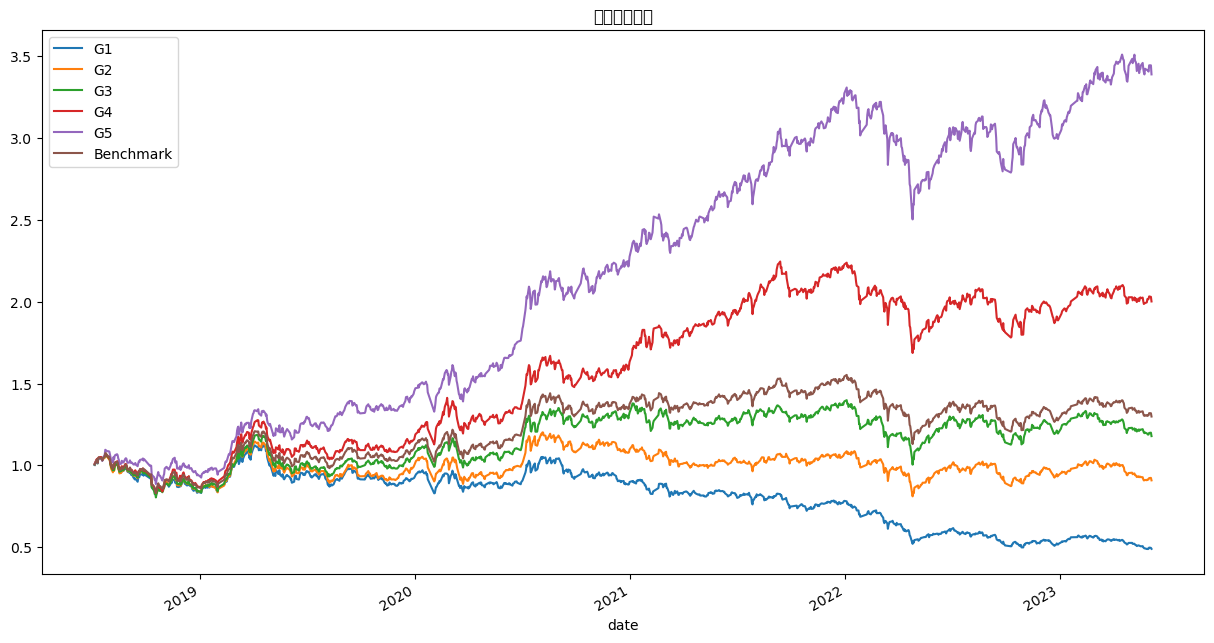

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_

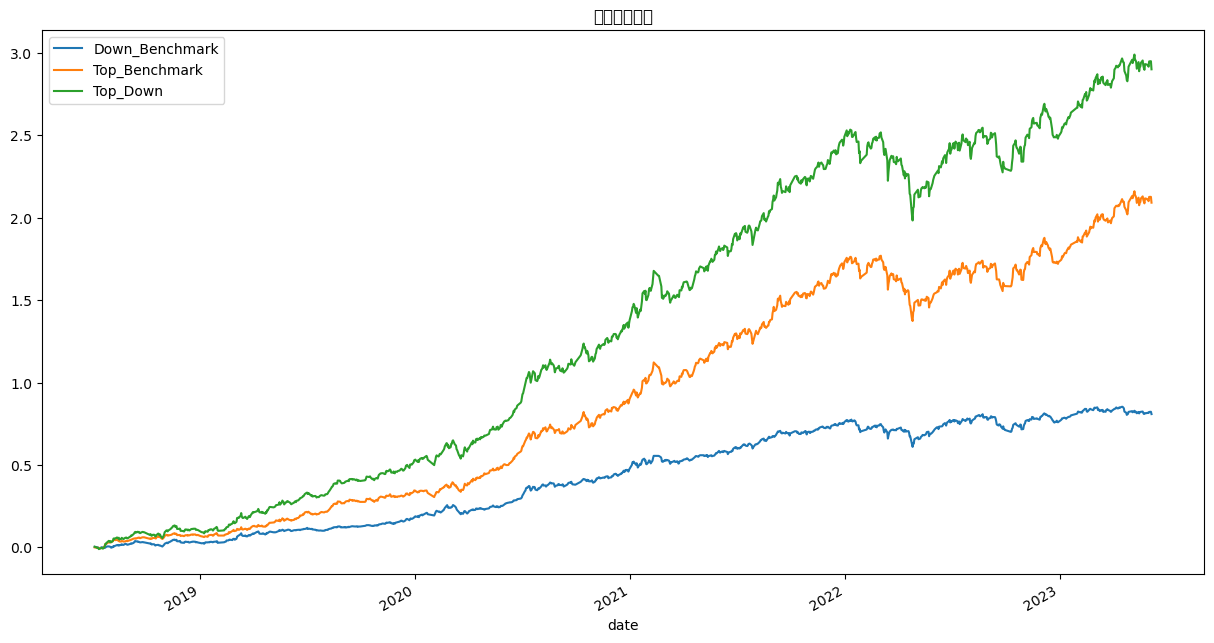

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25442 (\N{CJK UNIFIED IDEOGRAPH-6362}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_

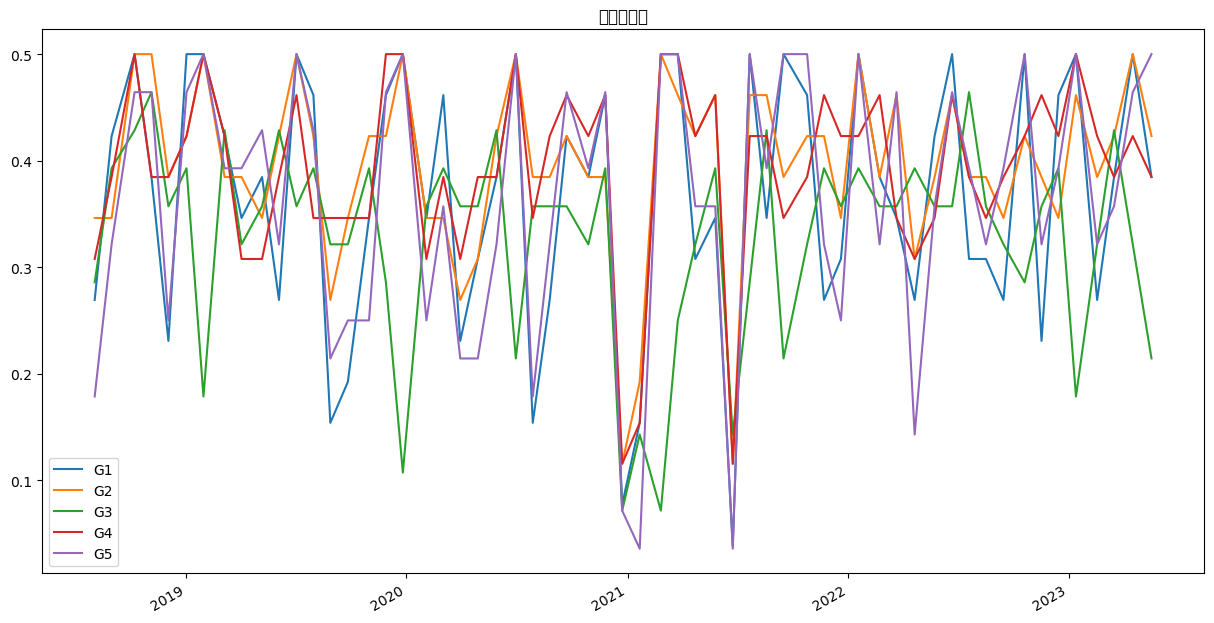

G1    0.366362
G2    0.395046
G3    0.328087
G4    0.392438
G5    0.364407
dtype: float64
710300行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801203.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801724.INDX行业指数因子值已构建

460800行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801204.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801074.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
801981.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801155.INDX行业指数因子值已构建

280500行业指数因子值缺失构建失败

450600行业指数因子值缺失构建失败

340800

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801155.INDX行业指数因子值已构建

280500行业指数因子值缺失构建失败

450600行业指数因子值缺失构建失败

340800行业指数因子值缺失构建失败

460600行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801194.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801083.INDX行业指数因子值已构建

630500行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801084.INDX行业指数因子值已构建

330700行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801082.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801733.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801741.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801744.INDX行业指数因子值已构建

421000行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801742.INDX行业指数因子值已构建

421100行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801713.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801722.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801101.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801193.INDX行业指数

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_

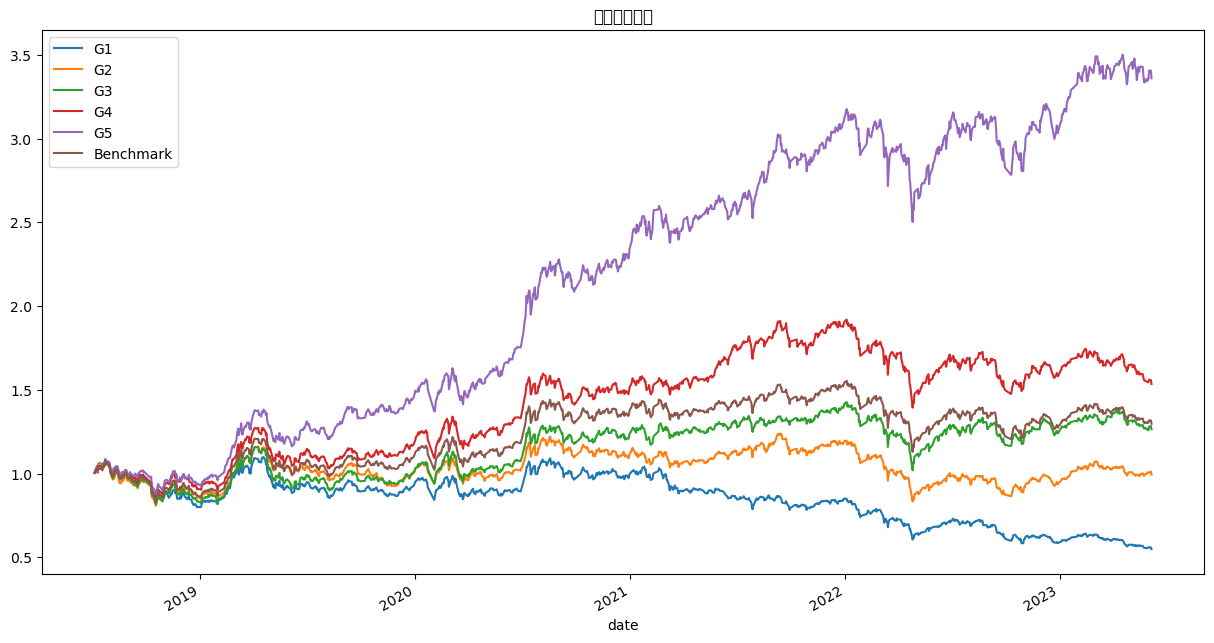

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_

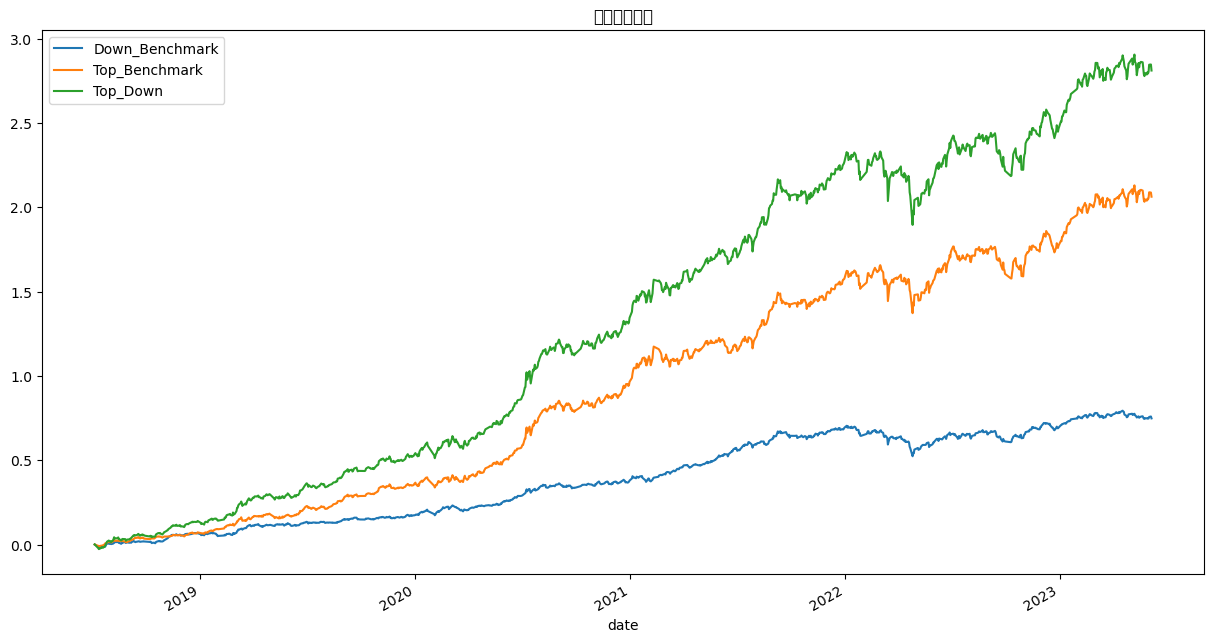

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25442 (\N{CJK UNIFIED IDEOGRAPH-6362}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_

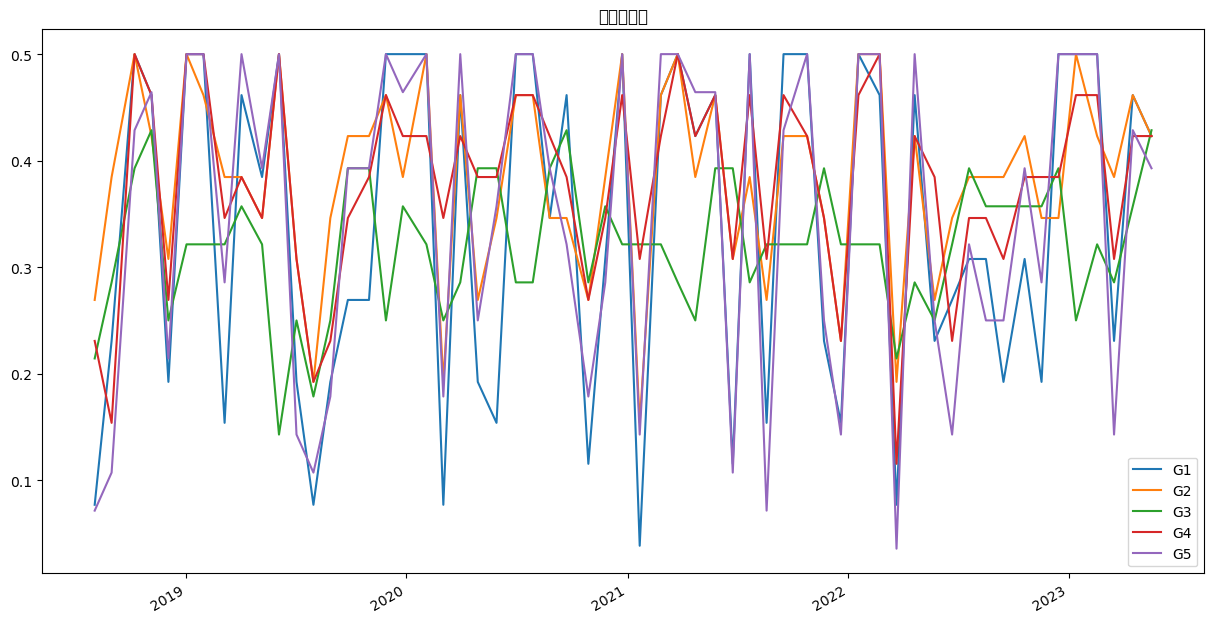

G1    0.339635
G2    0.382660
G3    0.320823
G4    0.378096
G5    0.348668
dtype: float64
710300行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801203.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801724.INDX行业指数因子值已构建

460800行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801204.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801074.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
801981.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801155.INDX行业指数因子值已构建

280500行业指数因子值缺失构建失败

450600行业指数因子值缺失构建失败

340800

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801055.INDX行业指数因子值已构建

620600行业指数因子值缺失构建失败

640600行业指数因子值缺失构建失败

720500行业指数因子值缺失构建失败

720600行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801181.INDX行业指数因子值已构建

430300行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801721.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801881.INDX行业指数因子值已构建

461100行业指数因子值缺失构建失败

720700行业指数因子值缺失构建失败

360500行业指数因子值缺失构建失败

461000行业指数因子值缺失构建失败

450700行业指数因子值缺失构建失败

230400行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801132.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完

因子完成市值中性化
行业因子完成加权计算
801084.INDX行业指数因子值已构建

330700行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801082.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801733.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801017.INDX行业指数因子值已构建

650500行业指数因子值缺失构建失败

110900行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801012.INDX行业指数因子值已构建

220800行业指数因子值缺失构建失败

480500行业指数因子值缺失构建失败

230300行业指数因子值缺失构建失败

720900行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801018.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
8011

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801093.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
801962.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
801961.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801085.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801015.INDX行业指数因子值已构建

720400行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
801963.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
801952.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
801951.INDX行业指

因子完成市值中性化
行业因子完成加权计算
801034.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801151.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801033.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801032.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801153.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801156.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
801983.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801154.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801231.INDX行业指数因子值已构建

480300行业指数因子值缺失构建失败

240600行业指数因子值缺失构建失败

640700行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801741.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801744.INDX行业指数因子值已构建

421000行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801742.INDX行业指数因子值已构建

421100行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801713.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801722.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801741.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
801744.INDX行业指数因子值缺失构建失败

421000行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801742.INDX行业指数因子值已构建

421100行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801713.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
801722.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801101.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801193.INDX行业指数因子值已构建

340900行业指数因子值缺失构建失败

 当前：202

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_

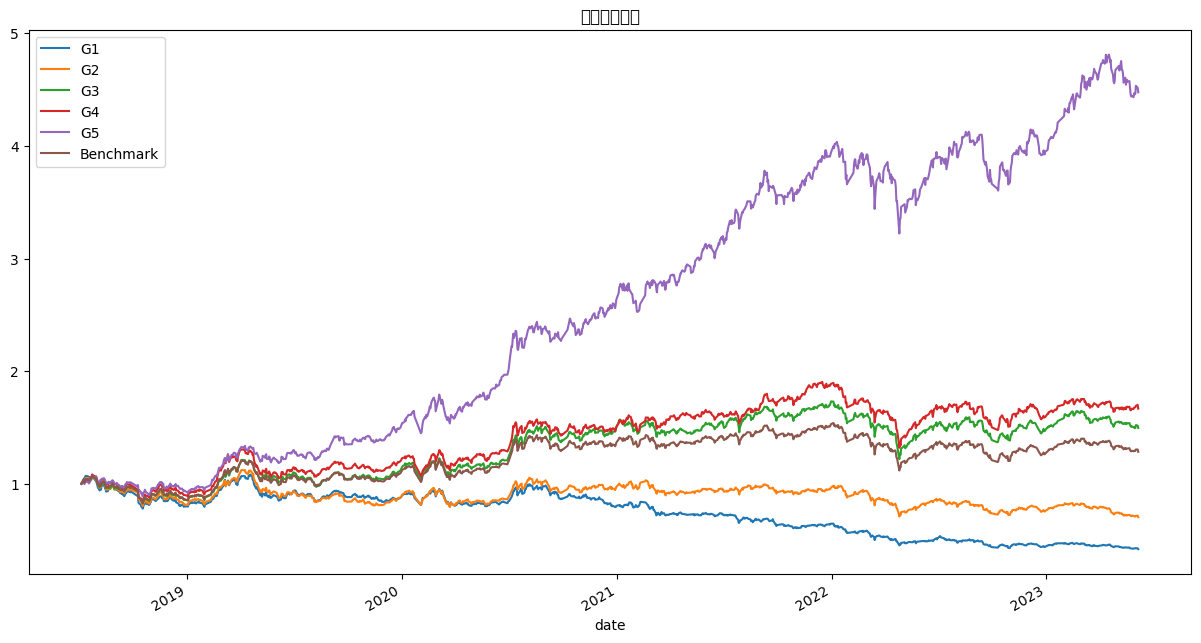

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_

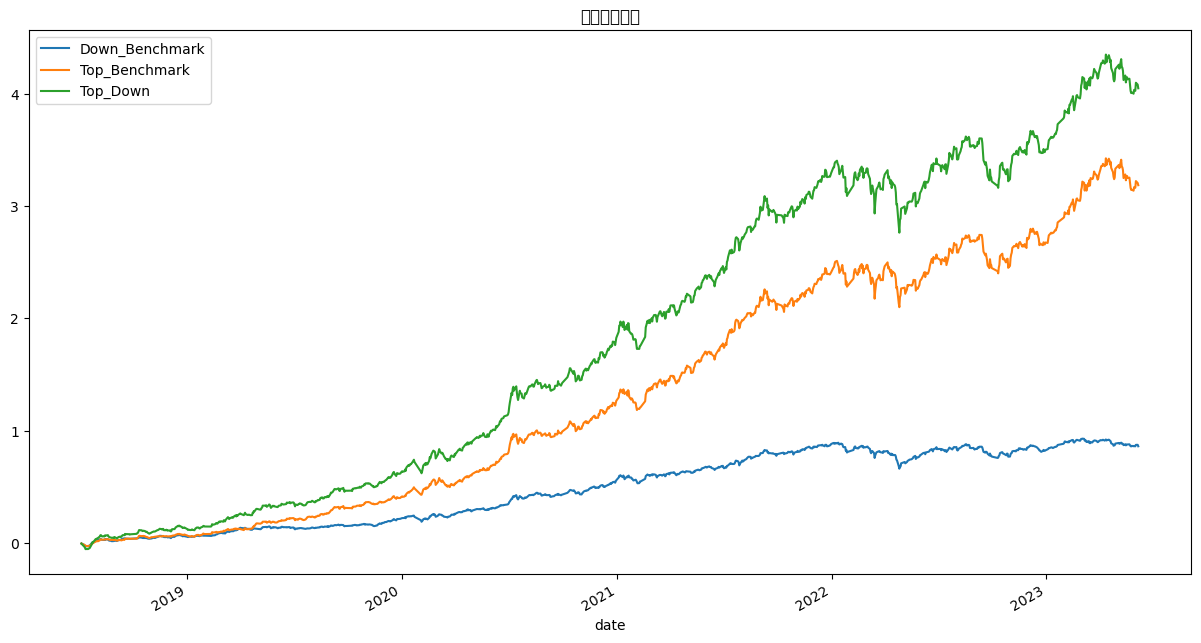

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25442 (\N{CJK UNIFIED IDEOGRAPH-6362}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_

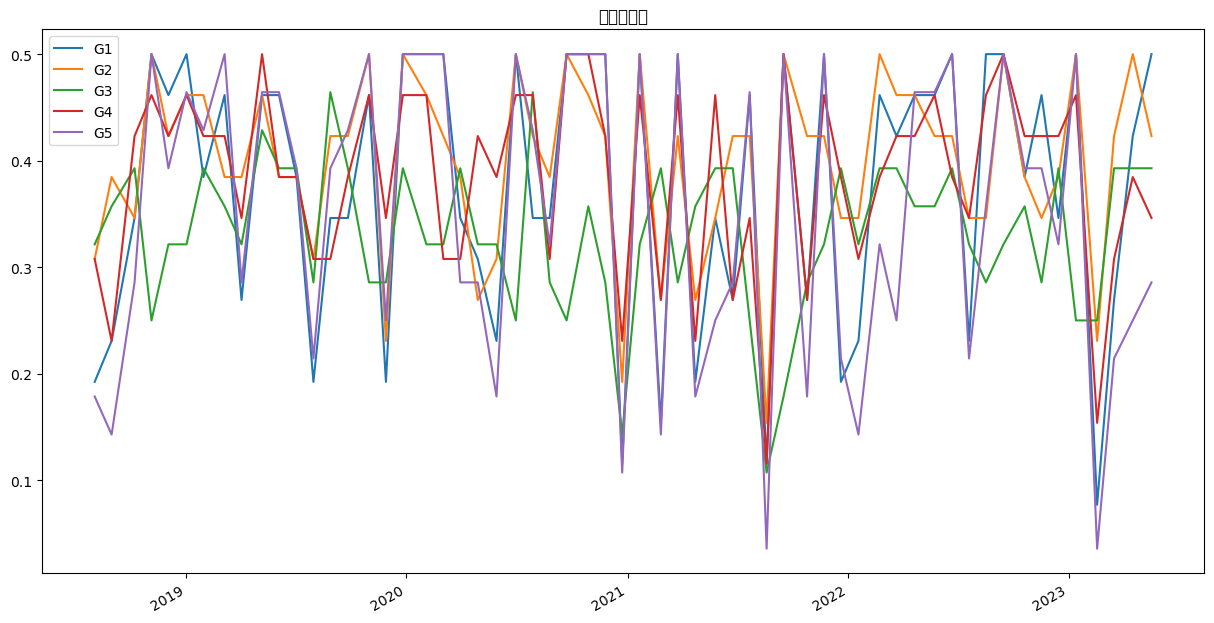

G1    0.374837
G2    0.398305
G3    0.332324
G4    0.383963
G5    0.351695
dtype: float64
710300行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801203.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801724.INDX行业指数因子值已构建

460800行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801204.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801074.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
801981.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801155.INDX行业指数因子值已构建

280500行业指数因子值缺失构建失败

450600行业指数因子值缺失构建失败

340800行业指数因子值缺失构

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801152.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801161.INDX行业指数因子值已构建

270600行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
801731.INDX行业指数因子值缺失构建失败

630700行业指数因子值缺失构建失败

630800行业指数因子值缺失构建失败

721000行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801111.INDX行业指数因子值已构建

340500行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
801016.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801131.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
801231.IN

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801151.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801033.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801032.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801153.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801156.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
801983.INDX行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801154.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801193.INDX行业指数因子值已构建

340900行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801053.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801202.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801076.INDX行业指数因子值已构建

710400行业指数因子值缺失构建失败

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801223.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801102.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：2023-07-06
剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
券池过滤完毕
因子数据清洗完成，已剔除离群值、中性化处理
因子完成市值中性化
行业因子完成加权计算
801072.INDX行业指数因子值已构建

 当前：2023-07-06 / 总量：202

In [ ]:
# Research period
start_date = input("start_date:")   # [example]: 2018-07-06
end_date = input("end_date:")       # [example]: 2023-07-06

# Enter the half-life (H)
H = int(input("Enter the half-life period:"))

# Load high-frequency datasets
file_path = 'data/high_frequency_data1.csv'
df1 = pd.read_csv(file_path)
df1 = df1[['S_INFO_WINDCODE', 'TRADE_DT', 'S_LI_INITIATIVEBUYRATE', 'S_LI_INITIATIVESELLRATE', 'S_LI_LARGEBUYRATE','S_LI_LARGESELLRATE']]
file_path = 'data/high_frequency_data2.csv'
df2 = pd.read_csv(file_path)
df2 = df2[['S_INFO_WINDCODE', 'TRADE_DT', 'S_LI_INITIATIVEBUYRATE', 'S_LI_INITIATIVESELLRATE', 'S_LI_LARGEBUYRATE','S_LI_LARGESELLRATE']]
df_combined = pd.concat([df1, df2])

# Remove duplicate rows using drop_duplicates
df_combined = df_combined.drop_duplicates()

# Ensure TRADE_DT is a date type
df_combined['TRADE_DT'] = pd.to_datetime(df_combined['TRADE_DT'], format='%Y%m%d')

# Use a mask to get data within the date range (data_df)
mask = (df_combined['TRADE_DT'] >= start_date) & (df_combined['TRADE_DT'] <= end_date)
data_df = df_combined.loc[mask]
data_df = data_df.sort_values(by='TRADE_DT')

# Data storage dictionary
factor_dict = {}

# Factor category list
factor_categories = [
    {
        'factor_names': ['cfoa_mrq','ccr_mrq','op_q_yoy_mrq','opr_mrq'],
        'factor_expressions': {
            'cfoa_mrq': Factor('cash_flow_from_operating_activities_mrq_0')/Factor('total_assets_mrq_0'),
            'ccr_mrq': Factor('cash_flow_from_operating_activities_mrq_0')/Factor('current_liabilities_mrq_0'),
            'op_q_yoy_mrq': (Factor('profit_from_operation_mrq_0') - Factor('profit_from_operation_mrq_4'))/ABS(Factor('profit_from_operation_mrq_4')),
            'opr_mrq': Factor('profit_from_operation_mrq_0') / Factor('operating_revenue_mrq_0')
        }
    },
    {
        'factor_names': ['sales_g_ttm','profit_g_ttm','roe_g_ttm','atdy_mrq'],
        'factor_expressions': {
            'sales_g_ttm': Factor('operating_revenue_growth_ratio_ttm')/1,
            'profit_g_ttm': Factor('net_profit_growth_ratio_ttm')/1,
            'roe_g_ttm': Factor('inc_return_on_equity_ttm')/1,
            'atdy_mrq': Factor('operating_revenue_mrq_0')/Factor('total_assets_mrq_0') - Factor('operating_revenue_mrq_4')/Factor('total_assets_mrq_4')
        }
    },
    {
        'factor_names': ['alpha_003','alpha_013','alpha_015','alpha_044','alpha_050'],
        'factor_expressions': {
            'alpha_003': Factor('WorldQuant_alpha003')/1,
            'alpha_013': Factor('WorldQuant_alpha013')/1,
            'alpha_015': Factor('WorldQuant_alpha015')/1,
            'alpha_044': Factor('WorldQuant_alpha044')/1,
            'alpha_050': Factor('WorldQuant_alpha050')/1
        }
    },
    {
        'factor_names': ['bp_ttm','ocfp_ttm','sp_ttm','dp_ttm'],
        'factor_expressions': {
            'bp_ttm': 1/Factor('pb_ratio_ttm'),
            'ocfp_ttm': Factor('cash_flow_from_operating_activities_ttm_0')/Factor('market_cap_3'),
            'sp_ttm': Factor('sp_ratio_ttm')/1,
            'dp_ttm': Factor('dividend_yield_ttm')/1
        }
    },
    {
        'factor_names': ['comp_con_ep_ftm','comp_con_bp_ftm','comp_con_eps_ftm'],
        'factor_expressions': {
            'comp_con_ep_ftm': 'comp_con_pe_ftm',
            'comp_con_bp_ftm': 'comp_con_pb_ftm',
            'comp_con_eps_ftm': 'comp_con_eps_ftm'
        }
    },
    {
        'factor_names': ['initiative_buy_rate', 'initiative_sell_rate', 'large_buy_rate', 'large_sell_rate'],
        'factor_expressions': {
            'initiative_buy_rate': 'S_LI_INITIATIVEBUYRATE',
            'initiative_sell_rate': 'S_LI_INITIATIVESELLRATE',
            'large_buy_rate': 'S_LI_LARGEBUYRATE',
            'large_sell_rate': 'S_LI_LARGESELLRATE'
        }
    }
]

# Iterate over each factor category
for index, factor_category in enumerate(factor_categories, start=1):
    factor_construction_df = factor_construction(start_date, end_date, factor_category['factor_names'], factor_category['factor_expressions'])
    # Store into the dictionary
    factor_dict[f'factor_category_{index}'] = factor_construction_df
    # Save each as a CSV file
    factor_construction_df.to_csv(f'factor_category_{index}.csv')

# Compute synthetic factor
synthetic_factor = calculate_synthetic_factor(factor_dict, H)
analyze_factor(synthetic_factor)

# Save synthetic factor to CSV
synthetic_factor.to_csv('synthetic_factor.csv')

## Stage 06: Data Cleaning & Preprocessing

The raw data is cleaned and transformed to ensure consistency:
- Handling missing values
- Aligning industry returns and factor exposures by date
- Normalizing or standardizing variables where needed
- Constructing factor-based scores for industries

In [ ]:
from src import cleaning

## Stage07: Outlier Detection & Analysis

['IC mean:0.5987', 'IC std:0.2909', 'IR:2.0583', 'IC>0:0.9497', 'ABS_IC>2%:0.9915', 't_stat:70.5235', 'p_value:0.0', 'skew:-0.9758', 'kurtosis:0.5699']
 当前：1180 / 总量：1194

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_

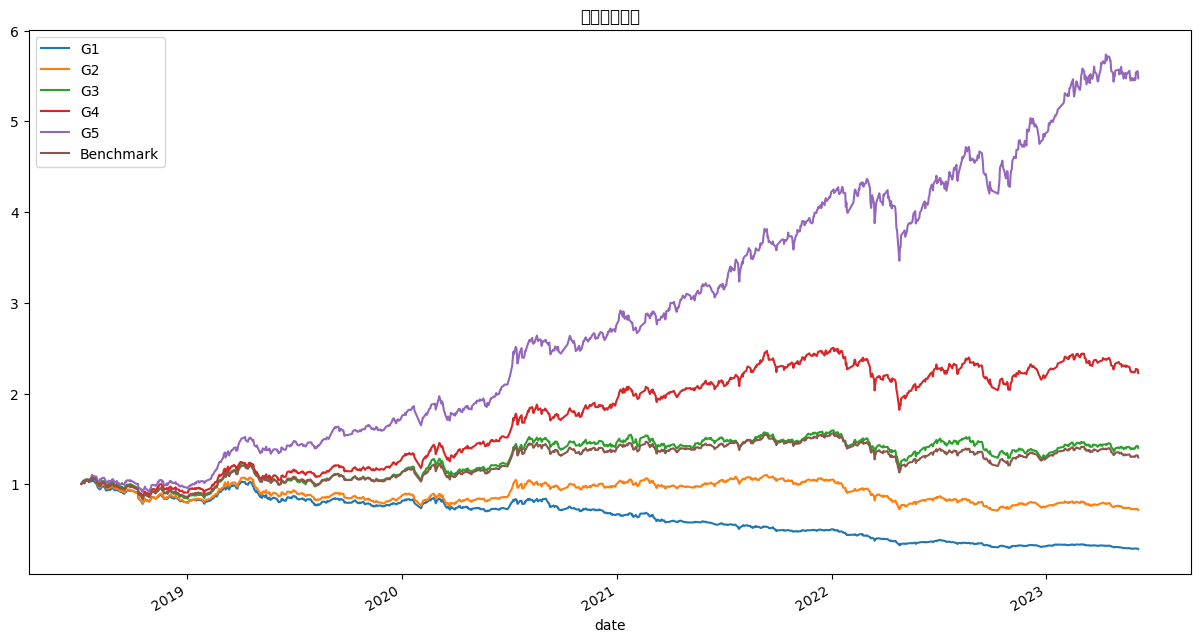

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_

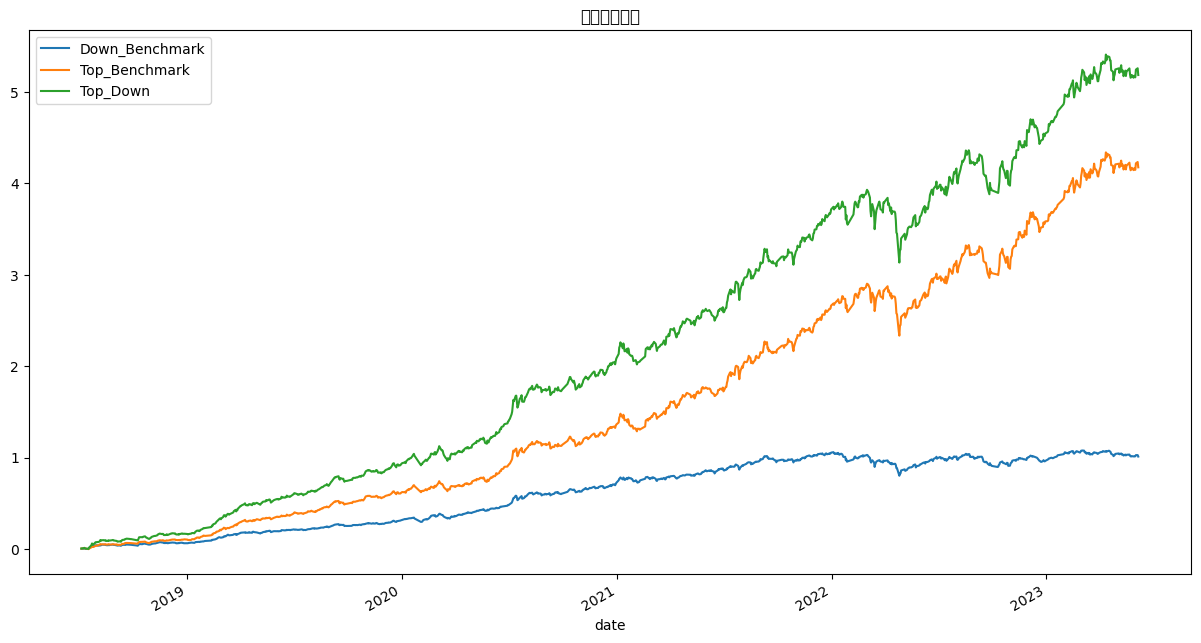

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25442 (\N{CJK UNIFIED IDEOGRAPH-6362}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_

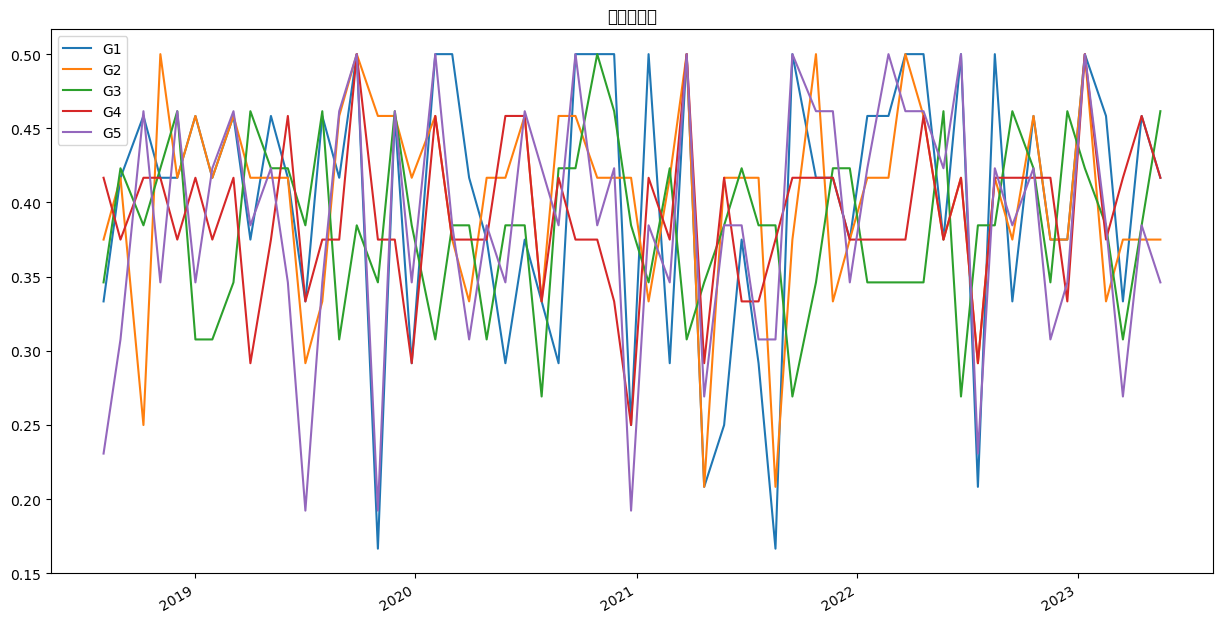

G1    0.399718
G2    0.402542
G3    0.383963
G4    0.390537
G5    0.386571
dtype: float64


In [ ]:
# Read data and plot
merged_dict = {}
H = 1
len(factor_categories)= 6

# Loop through each CSV file
for index in range(1, len(factor_categories)+1):
    # Use pandas read_csv to load data from CSV file
    df = pd.read_csv(f'factor_category_{index}.csv', parse_dates=['date'])
    # Set 'date' and 'stock' as a MultiIndex
    df.set_index(['date', 'stock'], inplace=True)
    # Save the DataFrame in the dictionary
    merged_dict[f'factor_category_{index}'] = df
    
factor_dict = merged_dict

# Compute the synthetic factor
synthetic_factor = calculate_synthetic_factor(factor_dict, H)
analyze_factor(synthetic_factor)

# Save the synthetic factor to a CSV file
synthetic_factor.to_csv('synthetic_factor.csv')

['IC mean:0.5987', 'IC std:0.2909', 'IR:2.0583', 'IC>0:0.9497', 'ABS_IC>2%:0.9915', 't_stat:70.5235', 'p_value:0.0', 'skew:-0.9758', 'kurtosis:0.5699']
 当前：1180 / 总量：1194

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24212 (\N{CJK UNIFIED IDEOGRAPH-5E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_

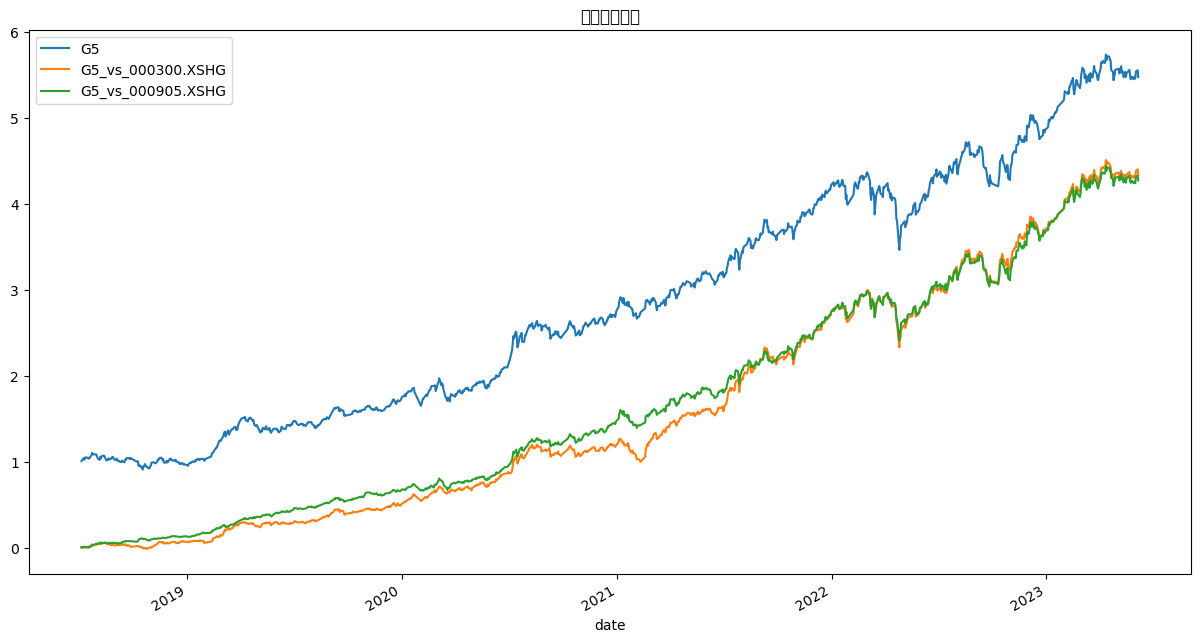

In [ ]:
# Relative excess plot vs CSI 300 and CSI 500
factor_df = synthetic_factor
factor_result = Group_Factor_Return_N_IC(factor_df, 20)
print(ic_ir(factor_result))

group1_5_period, turnover = group_5(factor_df, 20)
group1_5_period.columns = ['G1', 'G2', 'G3', 'G4', 'G5']
group1_5_period['Benchmark'] = group1_5_period.mean(axis=1)
group1_5_period = (group1_5_period + 1).cumprod()

# Get index data
indices_data = get_price(['000300.XSHG', '000905.XSHG'], 
                         get_previous_trading_date('2018-07-06',1,market='cn'),
                         '2023-07-06',
                         '1d','close','pre',False,True).close.unstack('order_book_id').pct_change().dropna(axis = 0,how = 'all')

# Convert indices_data to a DataFrame
indices_data_df = pd.DataFrame(indices_data)

# Compute cumulative returns of G5 relative to the indices
for index_name in indices_data_df.columns:
    group1_5_period['G5_vs_'+index_name] = group1_5_period['G5'] - (indices_data_df[index_name] + 1).cumprod()


# Plot the stratification effect test chart
plot_columns = ['G5', 'G5_vs_000300.XSHG', 'G5_vs_000905.XSHG']  # Only G5's cumulative returns relative to CSI 300 and CSI 500 indices
group1_5_period[plot_columns].plot(figsize=(15, 8), title='分层效应检验')
plt.show()